In [106]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torchesn.nn import ESN
from torchesn import utils
import time
import math

if torch.cuda.is_available():
  dev = 'cuda'
  print("Cuda avaiable. Device used to train the model:", dev)
else: 
  dev = 'cpu'
  print("Cuda not avaiable. Device used to train the model:", dev)


Cuda avaiable. Device used to train the model: cuda


# **A harmonic series dataset**

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [107]:
# First version of HarmonicSeriesDataset
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(self.harmonics*torch.sin(self.phases))
        return sample

# Dataset 
Let's generate a dataset and plot its content.

240
240
Samples.shape torch.Size([32, 240])
Samples.shape permuted torch.Size([1, 240, 32])


/tmp/ipykernel_11937/1425330012.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


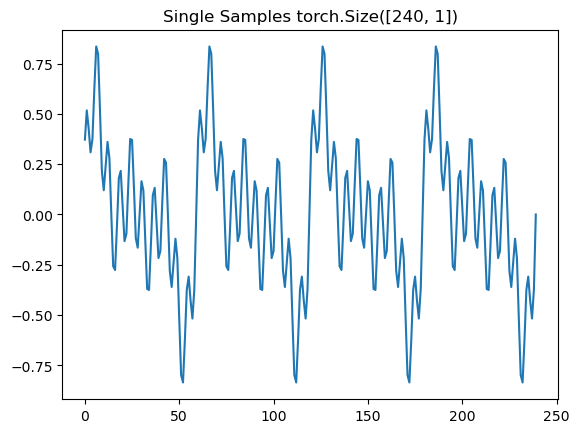

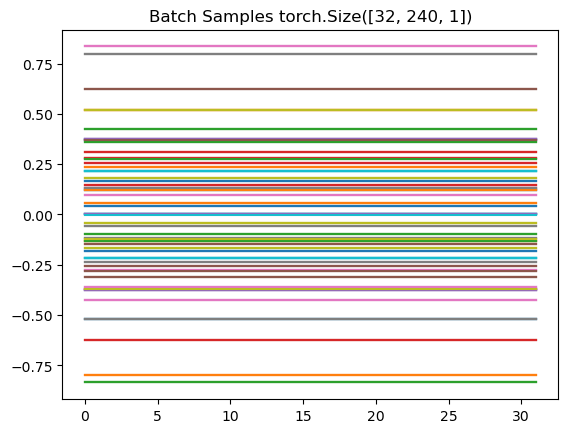

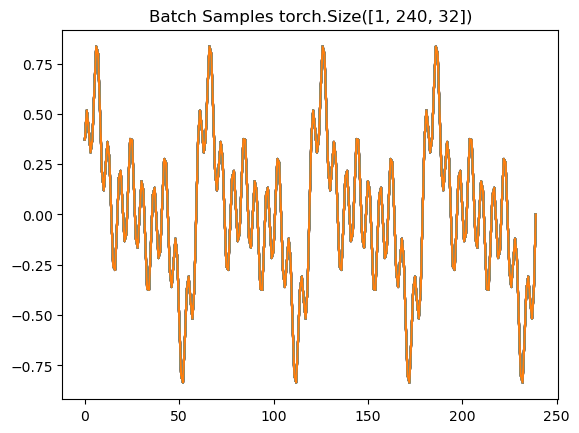

In [108]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
batch_size = 32
dataset = HarmonicSeriesDataset(harmonics,n_periods)
dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(dataloader)
print(period_len*n_periods)
print(signal_len)

samples = torch.zeros(batch_size,signal_len)

for i,sample in enumerate(dataloader):
      samples[:,i] = sample
      
train_samples = samples.unsqueeze(2)

# Plot dataset examples
print("Samples.shape",samples.shape)
print("Samples.shape permuted",train_samples.permute(2,1,0).shape)
plt.plot(train_samples[0,:,:].detach().numpy())
plt.title("Single Samples {}".format(train_samples[0,:,:].shape))
plt.show()
plt.plot(train_samples[:,:,0].detach().numpy())
plt.title("Batch Samples {}".format(train_samples.shape))
plt.show()
plt.plot(train_samples[:,:,0].permute(1,0).detach().numpy())
plt.title("Batch Samples {}".format(train_samples.permute(2,1,0).shape))
plt.show()

# **Echo State Network (ESN)**

## Offline Training [Pytorch-ESN/mackey-glass.py example]

Training error: 765.9993896484375
torch.Size([32, 240, 1])


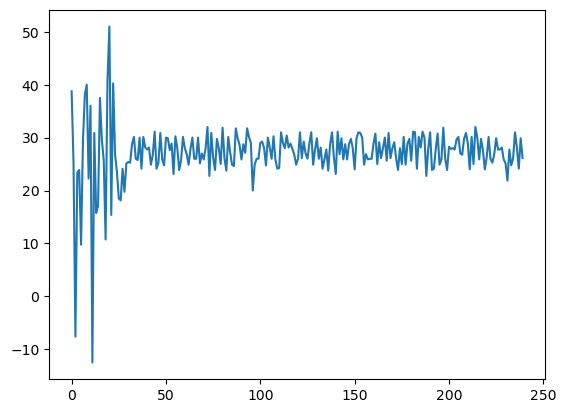

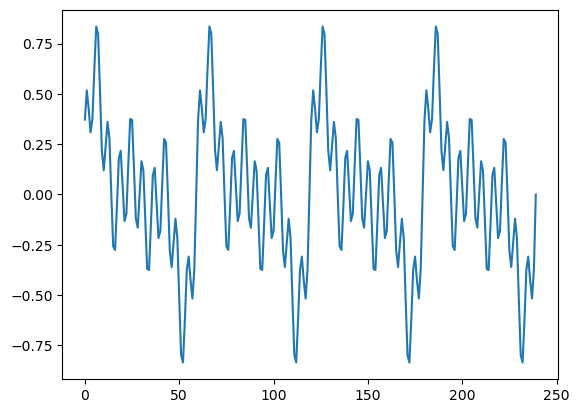

In [109]:
# Create net and configure training parameters
netest = ESN(1,64,1,1,batch_first=True)
netest.to(dev)
washout = (torch.ones(batch_size,1)*0).int()
train_seq = torch.ones(batch_size*train_samples.size(1),1).to(dev)
seq = torch.ones(batch_size,train_samples.size(1),1).to(dev)
loss_fcn = nn.MSELoss()

# Training
target_flat = utils.prepare_target(train_samples, (torch.ones(batch_size,1)*train_samples.size(1)).int(), washout, batch_first=True)
target_flat = target_flat.to(dev)

netest(seq, washout, None, target_flat)
netest.fit()
output, hidden = netest(seq, washout)
print("Training error:", loss_fcn(output, train_samples[:,washout[0]:,:].to(dev)).item())

print(output.shape)
plt.plot(output[0,:,:].detach().cpu().numpy())
plt.show()
plt.plot(train_samples[0,:,:].detach().cpu().numpy())
plt.show()

## Online Training (PyTorch optimizer)

In [110]:
def esn_evaluate_on_data(net, eval_data, target, device, plot=False):
  
  eval_data = eval_data.to(device) # ([N,L,1])
  target = target.to(device) # ([N,L,1])
  L = target.shape[1] # sequence length
  batch_size = target.shape[0] # batch size
  seq = torch.ones([batch_size,L,1]).to(device) # ([N,L,1])

  with torch.no_grad():
    pred,_ = net(seq,torch.zeros(batch_size,1))
  # Calculate evaluation loss
  eval_loss = torch.sum(torch.abs(target-pred))

  # Plotting results
  if(plot):
    fig, ax = plt.subplots()
    print("[TEST ON DATA] Eval loss {}".format(eval_loss))
    ax.plot(target[0,:,:].detach().cpu().numpy())
    ax.plot(pred[0,:,:].detach().cpu().numpy())
    plt.show()

  return eval_loss

def esn_train(net, epochs, train_samples, device):
  
    net.train()
    start = time.time() # Training Time
    
    #Define Loss, Optimizer, ecc.
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    target = train_samples.to(device)
    epochs_loss = np.zeros(epochs)
    best_eval_loss = np.inf

    L = target.shape[1]
    n_batches = target.shape[0]
    washout = (torch.ones(batch_size,1)*0).int()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        running_loss = 0.0
        seq = torch.ones([n_batches, L, 1]).to(device)
        
        prediction,_ = net(seq,washout)
        loss = criterion(prediction, target[:,washout[0,0]:,:])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        plot = True if (epoch%(epochs/16)==0) else False
        eval_loss = esn_evaluate_on_data(net, train_samples, target, device, plot=plot)
    
        epochs_loss[epoch] = eval_loss # For plotting loss during epochs

        if eval_loss < best_eval_loss:
         best_eval_loss = eval_loss
        torch.save(net.state_dict(), 'best_esn.pt')

        if (epoch%(epochs/20) == 0):
            print('Epoch: {}/{} .............'.format(epoch, epochs), end=' ')
            print("Train Loss: {:.4f} - Best Eval {:.4f}".format(running_loss, best_eval_loss))
    
        running_loss = 0.0

    print("---------- TRAINING FINISHED IN", time.time() - start, "SECONDS ----------")
    
    # Print Eval Loss
    x_ = np.linspace(0, epochs-1, epochs)
    y_ = epochs_loss
    yhat_ = signal.savgol_filter(y_, 101, 3) # Savitzky-Golay filter for smoothing

    fig, ax = plt.subplots()
    ax.plot(x_, y_)
    ax.plot(x_, yhat_)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Eval Loss') 
    # ax.grid(True) 
    plt.show()



In [111]:
def train_and_test_ESN(hidden_size, n_hidden_layers, train_data, target, epochs, device):

  net = ESN(input_size=1, hidden_size=hidden_size, output_size=1, num_layers=n_hidden_layers, batch_first=True)
  net = net.to(device)

  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("[INFO] Number of parameters: {}".format(params))
  
  # TRAINING
  esn_train(net, epochs, train_data, device)

  # TEST
  net.load_state_dict(torch.load('best_esn.pt'))  
  net.eval()
  esn_evaluate_on_data(net, train_data, target, device, plot=True)
  
  return net

[INFO] Number of parameters: 4289
[TEST ON DATA] Eval loss 2665.02099609375


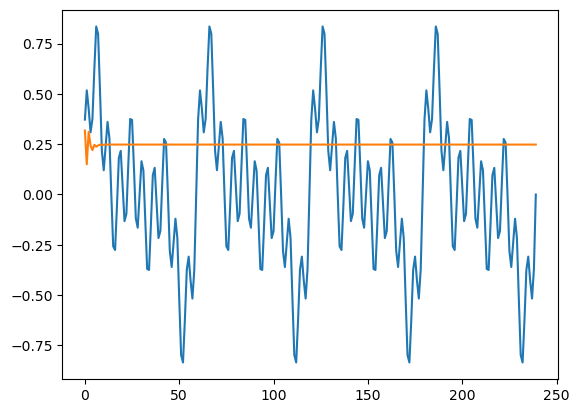

Epoch: 0/10000 ............. Train Loss: 0.3651 - Best Eval 2665.0210
Epoch: 500/10000 ............. Train Loss: 0.2812 - Best Eval 2158.0747
[TEST ON DATA] Eval loss 2153.4169921875


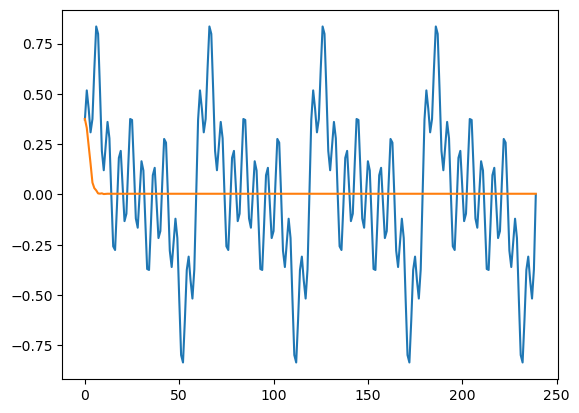

Epoch: 1000/10000 ............. Train Loss: 0.2781 - Best Eval 2135.8022
[TEST ON DATA] Eval loss 2131.658203125


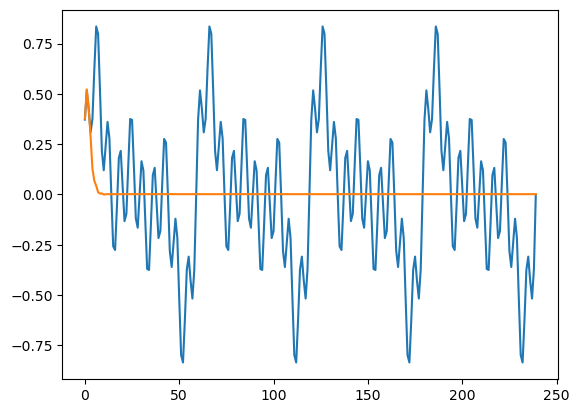

Epoch: 1500/10000 ............. Train Loss: 0.2774 - Best Eval 2128.8340
[TEST ON DATA] Eval loss 2130.0390625


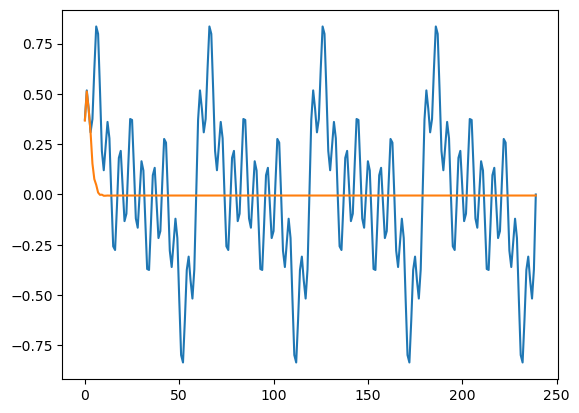

Epoch: 2000/10000 ............. Train Loss: 0.2771 - Best Eval 2127.5642
[TEST ON DATA] Eval loss 2130.1484375


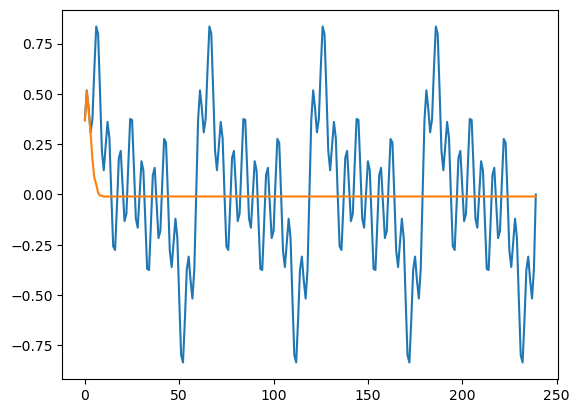

Epoch: 2500/10000 ............. Train Loss: 0.2775 - Best Eval 2126.4929
Epoch: 3000/10000 ............. Train Loss: 0.2767 - Best Eval 2124.9868
[TEST ON DATA] Eval loss 2125.84375


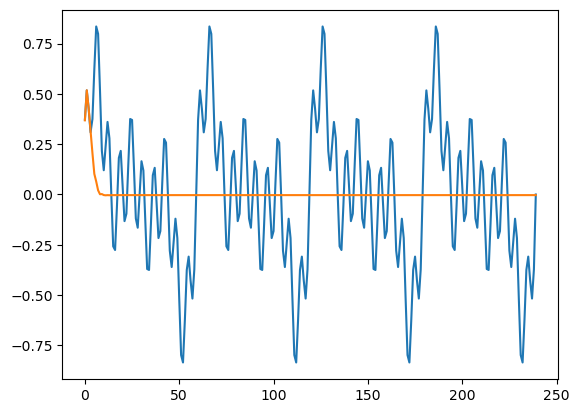

Epoch: 3500/10000 ............. Train Loss: 0.2766 - Best Eval 2123.8784
[TEST ON DATA] Eval loss 2123.50390625


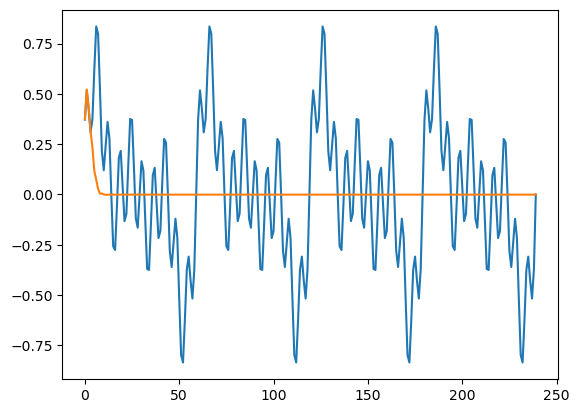

Epoch: 4000/10000 ............. Train Loss: 0.2764 - Best Eval 2122.3765
[TEST ON DATA] Eval loss 2122.238037109375


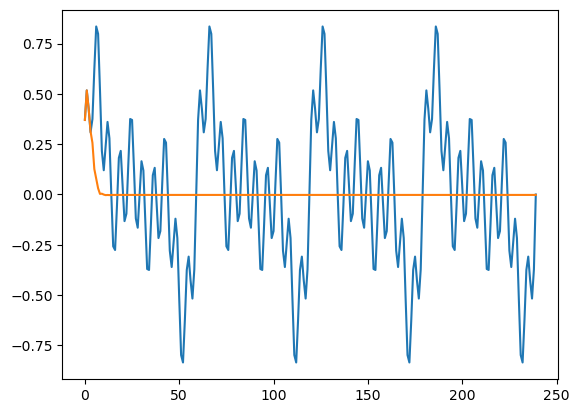

Epoch: 4500/10000 ............. Train Loss: 0.2763 - Best Eval 2121.4150
[TEST ON DATA] Eval loss 2120.1171875


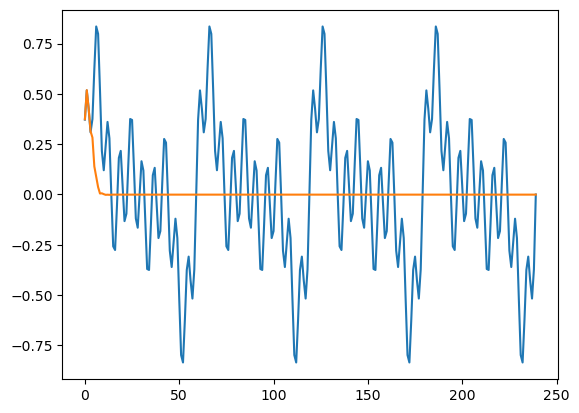

Epoch: 5000/10000 ............. Train Loss: 0.2764 - Best Eval 2119.9321
Epoch: 5500/10000 ............. Train Loss: 0.2762 - Best Eval 2118.5476
[TEST ON DATA] Eval loss 2119.62646484375


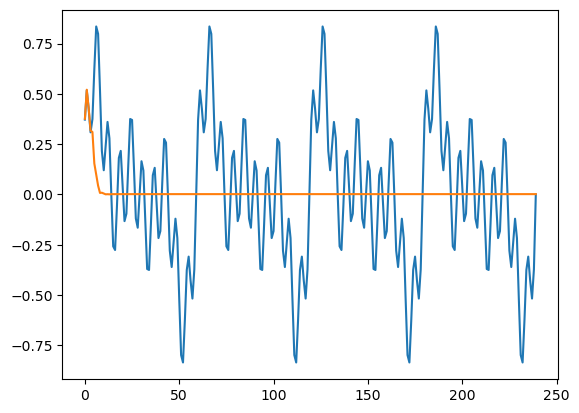

Epoch: 6000/10000 ............. Train Loss: 0.2758 - Best Eval 2117.3125
[TEST ON DATA] Eval loss 2117.059814453125


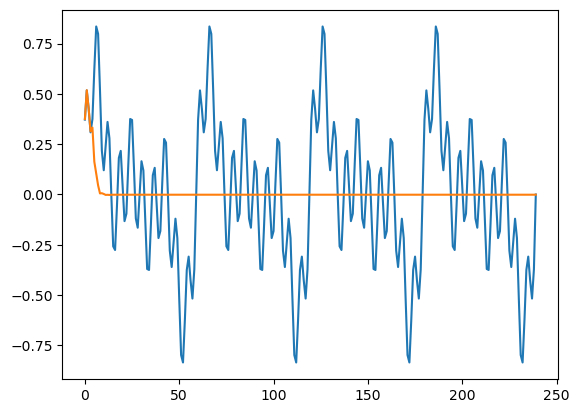

Epoch: 6500/10000 ............. Train Loss: 0.2759 - Best Eval 2116.2234
[TEST ON DATA] Eval loss 2115.452392578125


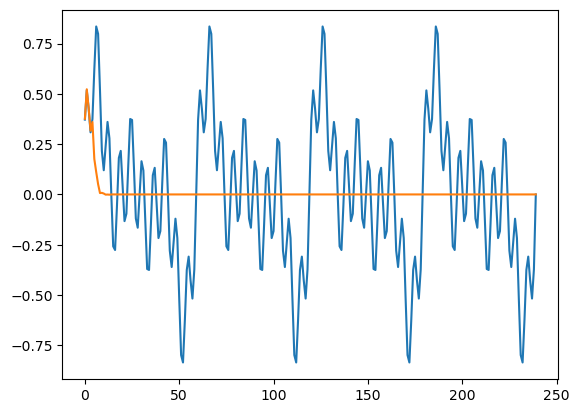

Epoch: 7000/10000 ............. Train Loss: 0.2756 - Best Eval 2114.8462
[TEST ON DATA] Eval loss 2116.109130859375


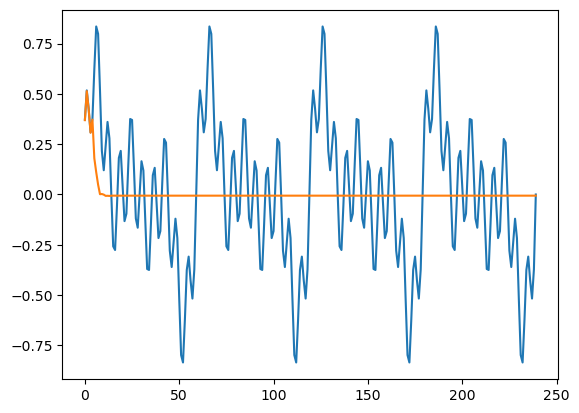

Epoch: 7500/10000 ............. Train Loss: 0.2753 - Best Eval 2113.8938
Epoch: 8000/10000 ............. Train Loss: 0.2754 - Best Eval 2113.7009
[TEST ON DATA] Eval loss 2115.9267578125


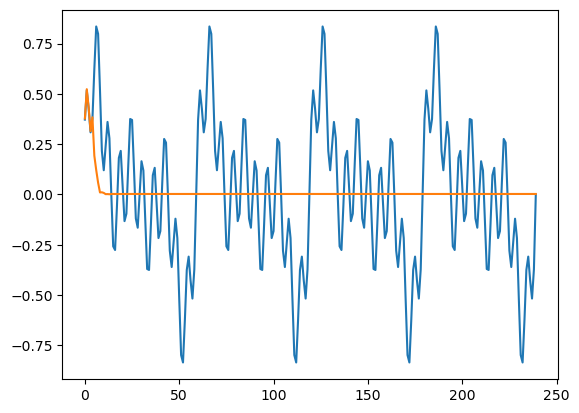

Epoch: 8500/10000 ............. Train Loss: 0.2754 - Best Eval 2113.5859
[TEST ON DATA] Eval loss 2114.10400390625


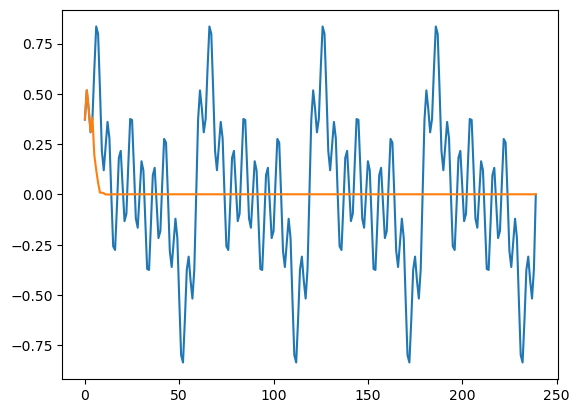

Epoch: 9000/10000 ............. Train Loss: 0.2754 - Best Eval 2113.4058
[TEST ON DATA] Eval loss 2116.497314453125


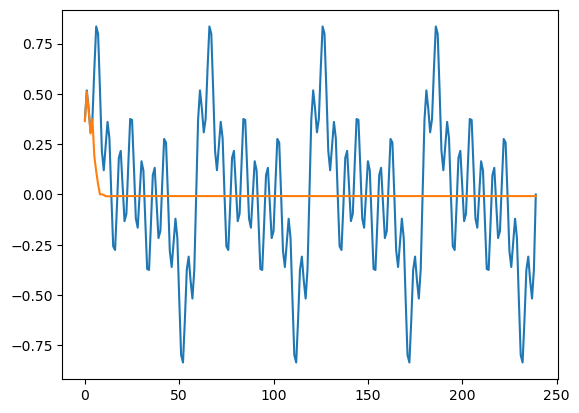

In [112]:
net = train_and_test_ESN(hidden_size=64, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=10000, device=dev)

# **Testing Trained ESNnet**

In [ ]:
seq = torch.ones(1,240,1)
seq = seq.to(dev)
out = net(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(out[0,:,:].detach().cpu().numpy())
plt.show()

seq = torch.ones(1,240,1)
seq[:,0:120,:] = 0
seq = seq.to(dev)
out = net(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(out[0,:,:].detach().cpu().numpy())
plt.show()